In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [164]:
dfs = [pd.read_csv('train.csv',header=0),pd.read_csv('test.csv',header=0)]
dfs[0].head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


# Get new features from datatime

In [165]:
for df in dfs:
    df.datetime = df.datetime.apply(pd.to_datetime)
    df['year']  = df.datetime.apply(lambda x : x.year)
    df['month'] = df.datetime.apply(lambda x : x.month)
    df['dayofweek'] = df.datetime.apply(lambda x : x.dayofweek)
    df['hour']  = df.datetime.apply(lambda x : x.hour)
dfs[0].head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1


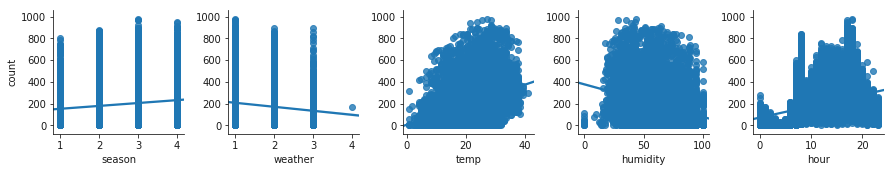

In [174]:
import seaborn as sns
sns.pairplot(dfs[0], x_vars=['season', 'weather','temp', 'humidity','hour'], y_vars='count', kind='reg')

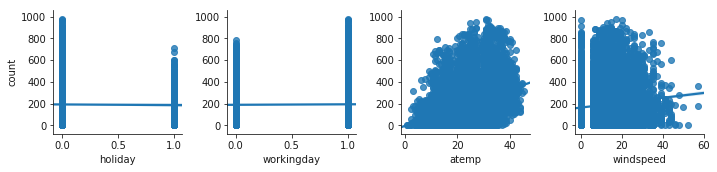

In [169]:
sns.pairplot(dfs[0], x_vars=['holiday', 'workingday','atemp', 'windspeed'], y_vars='count', kind='reg')

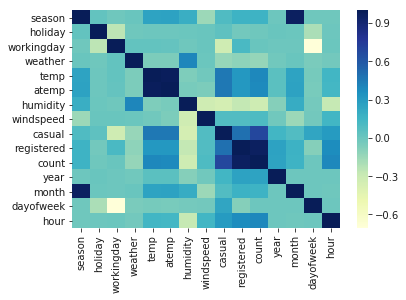

In [173]:
sns.heatmap(dfs[0].corr(),cmap="YlGnBu")

# Set categorical type

In [94]:
categoricalFeatureNames = ["holiday","workingday","weather","hour","year","month","dayofweek","season"]
for df in dfs:
    for var in categoricalFeatureNames:
        df[var] = df[var].astype("category",copy=False)   
        


# Remove outliners from dataset

In [95]:
print(dfs[0].shape)
dfs[0] = dfs[0][np.abs(dfs[0]["count"]-dfs[0]["count"].mean())<=(3*dfs[0]["count"].std())]  
print(dfs[0].shape)

(10886, 16)
(10739, 16)


In [96]:
data = dfs[0].append(dfs[1])
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)


In [97]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17232 entries, 0 to 17231
Data columns (total 16 columns):
atemp         17232 non-null float64
casual        10739 non-null float64
count         10739 non-null float64
datetime      17232 non-null datetime64[ns]
dayofweek     17232 non-null category
holiday       17232 non-null category
hour          17232 non-null category
humidity      17232 non-null int64
month         17232 non-null category
registered    10739 non-null float64
season        17232 non-null category
temp          17232 non-null float64
weather       17232 non-null category
windspeed     17232 non-null float64
workingday    17232 non-null category
year          17232 non-null category
dtypes: category(8), datetime64[ns](1), float64(6), int64(1)
memory usage: 1.2 MB
None


# Idea from kernels: predict 0's windspeed values by RF

In [98]:
# import xgboost as xg

# data['season'] = data['season'].astype("int32",copy=False)
# data['weather'] = data['weather'].astype("int32",copy=False)
# data['month'] = data['month'].astype("int32",copy=False)
# data['year'] = data['year'].astype("int32",copy=False)

# dataWind0 = data[data["windspeed"]==0]
# dataWindNot0 = data[data["windspeed"]!=0]
# xgrWind=xg.XGBRegressor()
# windColumns = ["season","weather","humidity","month","temp","year","atemp"]
# xgrWind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

# wind0Values = xgrWind.predict(dataWind0[windColumns])
# dataWind0["windspeed"] = wind0Values
# data = dataWindNot0.append(dataWind0)
# data.reset_index(inplace=True)
# data.drop('index',inplace=True,axis=1)

# Sunday and Monday is holidays

In [99]:
# add groupby



In [100]:
# data['workingday'] = data['workingday'].astype("int32",copy=False)
# data['holiday'] = data['holiday'].astype("int32",copy=False)
# data.loc[(data['workingday']==0) & (data['holiday']==0),'holiday']=1
# data['workingday'] = data['workingday'].astype("category",copy=False)
# data['holiday'] = data['holiday'].astype("category",copy=False)

# Slice train and test data

In [101]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
yLabels = dataTrain["count"]



In [102]:
y = yLabels.values.astype(np.float64)
y1 = dataTrain['registered'].values.astype(np.float32)
y2 = dataTrain['casual'].values.astype(np.float32)

dataTrain=dataTrain.drop(['datetime','casual','registered','count'],axis=1)
dataTest=dataTest.drop(['datetime','casual','registered','count'],axis=1)

x_train_main = dataTrain.values.astype(np.float64)
x_test_main = dataTest.values.astype(np.float64)


In [103]:
x_train_main.shape

(10739, 12)

In [104]:
print(y.shape,y1.shape,y2.shape)

(10739,) (10739,) (10739,)


# Define scores functions

In [112]:
def cross_val(x,y,modelx,cv=3,do_shuffle=False,loged=True):
    if x.shape[0]!=y.shape[0]:
        print("Wrong size of x,y.\n x size is  ",x.shape[0]," y size is ",y.shape[0])
        return
    
    if do_shuffle==True:
        x,y=shuffle(x,y)
        
    xs = np.array_split(x,cv,axis=0)
    ys = np.array_split(y,cv,axis=0)
    scores = np.zeros(cv)
    models = []
    
    for i in np.arange(cv):
        x_test = xs[i]
        y_test = ys[i]
        
        x_train = np.concatenate(np.delete(xs,i,0),axis=0)
        y_train = np.concatenate(np.delete(ys,i,0),axis=0)
#         model = RandomForestRegressor(n_estimators=360, max_depth= 10, max_features= 0.8, min_samples_split= 2)
        
#         model =xg.XGBRegressor(n_estimators=360,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.9,subsample=0.5)
        model = modelx
        model =model.fit(x_train,y_train)
        models.append(model) 
        predicted = model.predict(x_test)
        predicted = np.clip(predicted,a_min=0.693,a_max=1500)
#         predicted =rounds(0.05,0.95,predicted)

#         print('min~~',predicted.min(),x_test.shape)
        scores[i]= rmsle(y_test,predicted,loged=loged)

    return scores,models


def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def rounds(min,max,numbers):
    numbers = np.expm1(numbers)
    for i in np.arange(numbers.shape[0]):
        
        if (numbers[i]-np.fix(numbers[i]))>=max:
            numbers[i] =np.ceil(numbers[i])
        elif (numbers[i]-numbers[i].astype(int))<=min:
            numbers[i] =np.fix(numbers[i])
        
    numbers = np.log1p(numbers)
    return numbers
        


# Score function

In [106]:
def rmsle(y, y_,loged=True):
    if loged==False:
        log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
        log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    else:
        log1 = y
        log2 =y_
            
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))


# Make models:

### Lets try to predict log(x+1) values

In [107]:
log_y = np.log1p(y)

In [109]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor()
xgr=xg.XGBRegressor()
scores = cross_val_score(xgr, x_train_main, log_y, cv=3,scoring='neg_mean_squared_error')
print(scores)

[-0.34425128 -0.19080144 -0.16385395]


In [155]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xg

regressors = [
    linear_model.LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    svm.SVR(),
    DecisionTreeRegressor(),
    AdaBoostRegressor(),
    xg.XGBRegressor()
]
log = pd.DataFrame(columns=[["classifier", "log accuracy"]])
acc_dict = {}
for r in regressors:
    res,models=cross_val(x_train_main,log_y,r,cv=3,do_shuffle=False,loged=True)
    print(r.__class__.__name__,res.mean())
    name = r.__class__.__name__
    acc = res.mean()
    acc_dict[name]=acc


LinearRegression 1.03433014582
RandomForestRegressor 0.510458820975
GradientBoostingRegressor 0.477908230306
SVR 1.10128770765
DecisionTreeRegressor 0.626038891147
AdaBoostRegressor 0.752393783679
XGBRegressor 0.476108774114


# Grid Search for RandomForest and XGBoost

In [ ]:
import xgboost as xg
from time import time
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(x_train_main, log_y, test_size = 0.33, random_state = 22)
rf = RandomForestRegressor()
xgr=xg.XGBRegressor()
param_grid = {"max_depth": [6],
              "min_child_weight": [3,4,5],
              "gamma" : [0.5,0.4],
              "colsample_bytree": [0.9,0.8],
              "subsample":[0.6,0.5]}
grid_search = GridSearchCV(xgr, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)
# prediction = rf.predict(X_test)
# prediction = prediction.astype(np.float32)
# rmsle(y_test, prediction) 
# mean_squared_error(y_test, prediction) 

In [126]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from time import time
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(x_train_main, log_y, test_size = 0.33, random_state = 22)
rf = RandomForestRegressor()
xgr=xg.XGBRegressor()
param_grid = { "n_estimators"      : [360],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
grid_search = GridSearchCV(rf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))


GridSearchCV took 441.12 seconds for 80 candidate parameter settings.


In [127]:
print (grid_search.best_params_)
# XGBoost'colsample_bytree': 0.9, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6
# RF {'max_depth': 10, 'max_features': 0.8, 'min_samples_split': 2, 'n_estimators': 360}

{'max_depth': 10, 'max_features': 0.8, 'min_samples_split': 2, 'n_estimators': 360}


In [157]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg
from sklearn import svm

regressors = []
rf = RandomForestRegressor(max_depth=10, max_features=0.8, min_samples_split=2, n_estimators=360)
xgr=xg.XGBRegressor(n_estimators=360,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.9,subsample=0.5)

res,models=cross_val(x_train_main,log_y,xgr,cv=3,do_shuffle=False,loged=True)
print(res,res.mean(),' score for XGBoost')

res2,models2=cross_val(x_train_main,log_y,rf,cv=3,do_shuffle=False,loged=True)
print(res2,res2.mean(),' score for RF')

[ 0.4899934   0.40949601  0.32392383] 0.407804412054  score for XGBoost
[ 0.60522737  0.51773506  0.41731464] 0.513425692765  score for RF


# Submit to csv

In [161]:
from sklearn.ensemble import RandomForestRegressor
xgr=xg.XGBRegressor(n_estimators=360,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.9,subsample=0.5)
xgr.fit(x_train_main,log_y)
pred_y =xgr.predict(x_test_main)
submit_y = np.expm1(pred_y)



In [162]:


submit_ex = pd.read_csv('sampleSubmission.csv',header=0)
submit_ex['count'] = submit_y.astype(np.float32)
submit_ex.to_csv('submit.csv',index=False)
submit_ex.head(5)

,datetime,count
0,2011-01-20 00:00:00,11.272060
1,2011-01-20 01:00:00,4.793510
2,2011-01-20 02:00:00,3.027211
3,2011-01-20 03:00:00,1.830152
4,2011-01-20 04:00:00,1.459649


## Last submited scores:

In [146]:
print('1)',0.48759,' 1384\'s place')#Rforest
print('2)',0.41674,' 420\'s place ~ top ',np.round(420*100/3252,2), ' %')#XGboost
print('3)',0.41485,' 382\'s place ~ top ',np.round(382*100/3252,2), ' %')

1) 0.48759  1384's place
2) 0.41674  420's place ~ top  12.92  %
3) 0.41485  382's place ~ top  11.75  %
